# DATA SECTION

store_id : 상점의 고유 아이디

card_id : 사용한 카드의 고유 아이디

card_company : 비식별화된 카드 회사

trasacted_date : 거래 날짜

transacted_time : 거래 시간( 시:분 )

installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )

region : 상점의 지역

type_of_business : 상점의 업종

amount : 거래액(단위는 원이 아닙니다)

# 기본 세팅

In [ ]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer
import statsmodels.api as sm

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MAE (Mean Absolute Error) : 절댓값 오차의 평균 식 세우기

In [ ]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

# Issue
1) 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음
month 주기로 resampling 후 forecast 범위를 3개월로 지정하여 해결


2) 1967개의 store_id가 각각의 trend와 seasonality를 가지고 있음
같은 알고리즘에서 각 store_id별로 parameter를 조절한다.


3) 예측 날짜는 2019-03~2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 있다. 마지막 날짜부터 3개월만 예측하여 제출한다.

(ex: store_id 111의 마지막 날짜는 2018-09월로 뒤 3개월인 2018-10~2018-12만 예측하여 제출)

예측 기간이 길어질수록 오차가 크게 발생하여 바로 뒤 3개월만 예측하는 것이 정확도가 높았음

# STEP1. DATA LOAD

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/funda_train.csv')#펀다에서 제공한 데이터셋을 읽음
df_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/submission.csv')#제출하는 데이터셋 파일을 읽음
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])#transacted_Date에 있는 날짜 형식을 통일시킴(거래 시간)

print(df_train.shape)#데이터셋의 모양(개수) 출력

(6556613, 9)


In [ ]:
frame_info = [(col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5]) for col in df_train.columns]
#표의 항목에 들어갈 항목들 구성. 
#col = 데이터 종류의 이름, len(df_train[col].unique()) = 종류의 수, df_train[col].isnull().sum() = null의 개수, df_trian[col].dtype = 데이터 타입, df_train[col].unique()[:5] for col in df_train.colums = 첫 5개 데이터 예시
df_info = pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])#목차 이름들
#dataFrame함수로 표를 구성함

In [ ]:
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,datetime64[ns],"[2016-06-01T00:00:00.000000000, 2016-06-02T00:..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


##시계열 분석을 위해 date 정보를 index로 변환

In [ ]:
df_train = df_train.set_index('transacted_date')#거래 날짜를 기준 목차로 함
df_train.head(3)#맨 앞 3개 항목 출력

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000


## **시간 단위로 나뉘어져 있는 데이터를 일단위로 resampling**

* 'store_id', 'region', 'type_of_business' 기존과 동일
* day_of_week : 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
* business_day : working day 여부, 1이면 working day 0이면 주말
* num_of_pay : 일 결제 건수, 'card_id'의 count로 생성
* num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
* installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
* amount : 일 매출 액, 기존 amount의 합


In [ ]:
def resample_day(train_df):#일단위로 리샘플링 하는 함수 만들기
  df_day = pd.DataFrame()#표 형태로 출력
  for i in train_df.store_id.unique(): #가게 개수만큼 반복
    df_num = train_df[train_df.store_id == i]#현재 순서에 해당하는 가게에 대해 아래에서 그 정보를 정리함

    count_cols = df_num['card_id'].resample(rule = 'd').count().rename('num_of_pay')
    #resample함수가 단위임. 그 단위로 나눠서 count는 그 갯수 그 갯수의 이름은 num of pay
    #card_id의 일별 counting을 통해 일 거래 횟수 확인
    revisit_idx = df_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values
    #card_id의 value count가 2보다 크면 단골인 것으로 판단하고 단골 방문 횟수 확인
    #reset_index로 card_id를 표 안으로 들임 그래서 그 값을 value_counts()로 등장횟수를 세는 것
    #2보다 많이 나오면 revisit_idx에 저장
    revisit_ct = df_num[df_num.card_id.isin(revisit_idx)].card_id.resample(rule = 'd').count().rename('num_of_revisit')
    #revisit_idx가 속한 card_id가 결제된 가게의 card_id 개수를 resample로 날짜마다 세어서 num_of_revisit에 저장
    sum_cols = df_num[['installment_term','amount']].resample(rule='d').sum()
    #할부 개월수와 매출액은 일 단위로 합

    df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)
    #concat으로 데이터 합치기 axis가 1이라서 옆으로 한 목록씩 합쳐짐

    df_num_day.insert(0, 'store_id', i) #첫 칸에 가게 아이디 삽입
    df_num_day.insert(4, 'region', df_num[df_num.store_id == i].region.unique()[0])
    #가게 아이디에서 unique한 것 중 첫번째 것 추가(물론 지역이 여러개일순 없겠지만 오류도 있을 수 잇으니 안전하게..)
    df_num_day.insert(5, 'type_of_business', df_num[df_num.store_id == i].type_of_business.unique()[0])
    #위와 동일
    
    df_day = pd.concat([df_day, df_num_day], axis=0)
    #axis=0이라 위 아래로 데이터 합침. 그런데 df_day는 빈칸이라 ㄱㅊ음
  
  df_day.insert(1, 'day_of_week', df_day.index.dayofweek) #일주일 표시
  df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)#영업일 표시
  df_day.num_of_revisit.fillna(0, inplace = True) #재방문없어서 null인 곳은 0으로 채워줌

  return df_day #최종 dataFrame 출력


In [ ]:
%%time
df_day = resample_day(df_train)
#이제 df_day라는 변수에 df_train데이터셋을 일단위 리샘플링 함수에 넣어서 리샘플링하기

CPU times: user 3min 24s, sys: 3.84 s, total: 3min 28s
Wall time: 3min 28s


In [ ]:
df_day.head(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714


In [ ]:
df_day.isnull().sum() #값이 0인 것의 합

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [ ]:
daily_corr = df_day.corr()
daily_corr #step4에 쓰일 회귀분석을 위해 상관관계 분석을 미리 해봄

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,-0.00004,0.00001,0.04237,0.00806,-0.01218,-0.01835
day_of_week,-0.00004,1.00000,-0.79052,0.01672,-0.03869,-0.01395,-0.02150
business_day,0.00001,-0.79052,1.00000,-0.00460,0.05721,0.01530,0.02947
num_of_pay,0.04237,0.01672,-0.00460,1.00000,0.70112,0.09414,0.26525
num_of_revisit,0.00806,-0.03869,0.05721,0.70112,1.00000,0.07113,0.26067
installment_term,-0.01218,-0.01395,0.01530,0.09414,0.07113,1.00000,0.26750
amount,-0.01835,-0.02150,0.02947,0.26525,0.26067,0.26750,1.00000


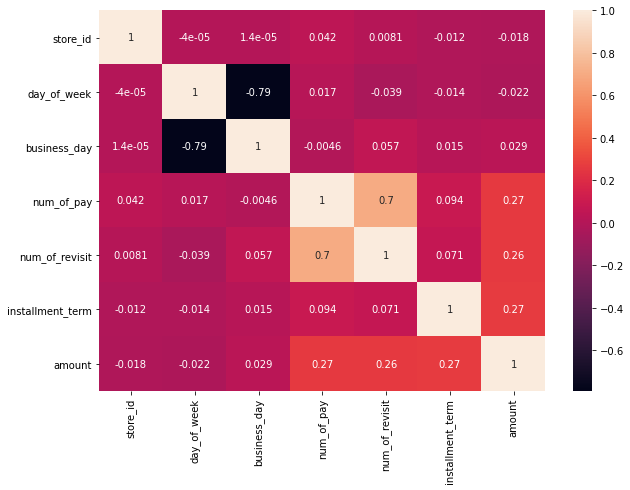

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.heatmap(daily_corr, annot=True)

## **Modeling을 위해 Month 단위로 resampling**

In [ ]:
df_day.head(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714


In [ ]:
def resample_month(frame_day):
  sum_cols = ['num_of_pay', 'num_of_revisit','installment_term','amount']

  df_monthly = pd.DataFrame() #새 데이터프레임 생성

  for i in frame_day.store_id.unique():
    df_set = frame_day[frame_day.store_id == i]

    # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
    prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
    #이전 달에 대한 정보
    add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
    #이후 달에 대한 정보
    df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)
    #데이터셋에 이전달, 현재달, 다음달 순으로 위에서 아래로 데이터 정렬

    df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
    df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1
    #각 월에 해당하는 정보를 정렬함.그 자리에 1을 넣음... 왜지??
    #null값 때문에 오류가 생겨서 그렇다는데,,, 나의 머리는 이해를 할 수가 없다.. 살려조라
    
    tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
    #데이터 중 매출이 0이 아닌 날의 요일을 꼽아 그 개수를 셈
    business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')
    #데이터 중 매출이 0이 아닌 날 중 영업일을 모두 더함(어차피 영업일은 1, 휴무일은 0이기 때문)

    business = business.drop([business.index[0], business.index[-1]], axis=0)
    #처음과 끝 줄에 있는 정보들을 삭제
    tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
    #처음과 끝 줄에 있는 정보들을 삭제
    df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)
    #처음과 끝에 있는 정보들을 삭제
    #왜지..? 

    df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)
    #정리한 데이터들을 옆으로 정렬. sum은 매출액

    df.insert(0, 'store_id', i)
    #가게 아이디 추가
    df.insert(6, 'region', df_set.region.values[0])
    #지역 추가
    df.insert(7, 'type_of_business', df_set.type_of_business.values[0])
    #업종 추가

    df_monthly = pd.concat([df_monthly, df], axis=0)
    #최종 dataframe변수를 설정하여 여기에 반복해서 만든 df_monthly와 새 df를 합해서 최종 df_monthly를 제작함
   
  return df_monthly

In [ ]:
%%time
df_month = resample_month(df_day)

CPU times: user 1min 15s, sys: 294 ms, total: 1min 15s
Wall time: 1min 15s


In [ ]:
df_month.isnull().sum() #null값 개수 계산

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [ ]:
print("rate of 'region' :", df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :", df_month.type_of_business.isnull().sum() / len(df_month))
#각 항목에서 null값이 차지하는 비율 확인

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


* null값의 비율이 너무 많아서 오류를 줄이기 위해 삭제



In [ ]:
df_month = df_month.drop(['region','type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [ ]:
df_month.to_csv('/content/drive/My Drive/Colab Notebooks/funda_train_month.csv')
#파일로 남김

In [ ]:
df_month = pd.read_csv('/content/drive/My Drive/Colab Notebooks/funda_train_month.csv')
#다시 읽음
df_month.rename(columns={'Unnamed: 0' : 'transacted_date'}, inplace=True)
#항목 이름 지정
df_month['transacted_date'] = pd.to_datetime(df_month['transacted_date'])
#항목 내용 형식을 통일
df_month = df_month.set_index('transacted_date')
#결제일을 기준으로 정렬

In [ ]:
print(df_month.shape)
df_month.head()

(60915, 7)


,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
transacted_date,,,,,,,
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143


# STEP2. EDA

## 변수의 describe확인

In [ ]:
df_month.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000
mean,1050.48428,21.06987,15.89640,107.63544,40.01136,14.87540,1123187.83063
std,617.48320,7.75327,5.63136,101.24413,43.88133,33.42161,1753567.15171
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-514285.71429
25%,515.00000,16.00000,12.00000,32.00000,11.00000,0.00000,339642.85714
50%,1039.00000,23.00000,17.00000,73.00000,26.00000,3.00000,710714.28571
75%,1587.00000,28.00000,21.00000,159.00000,54.00000,14.00000,1344650.00000
max,2136.00000,31.00000,23.00000,2186.00000,2154.00000,1125.00000,61429316.14286


## target 변수의 대칭성(정규성)확인

Skewness : 0.48245510908400707


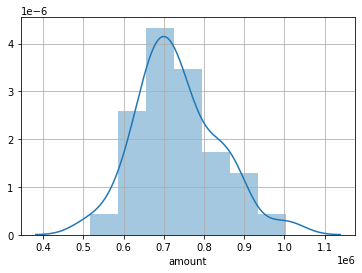

Skewness : 0.510252105069473


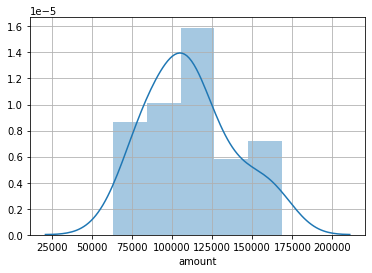

Skewness : 0.9982599271676977


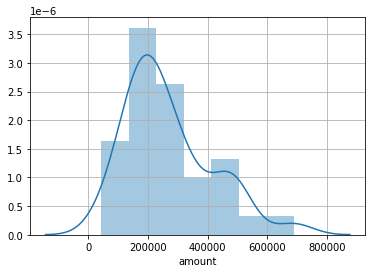

In [ ]:
for i in df_month.store_id.unique()[:3]:
    print("Skewness :", df_month[df_month.store_id == i].amount.skew())
    #skewness = 비대칭도
    sns.distplot(df_month[df_month.store_id == i].amount)
    plt.grid()
    plt.show()

-0.5308009496851174


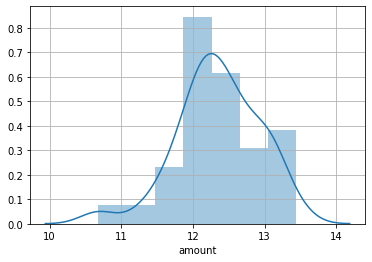

In [ ]:
print(np.log(df_month[df_month.store_id == 2].amount).skew())
sns.distplot(np.log(df_month[df_month.store_id == 2].amount))
plt.grid()
plt.show()

## 각 변수의 value 분포 시각화

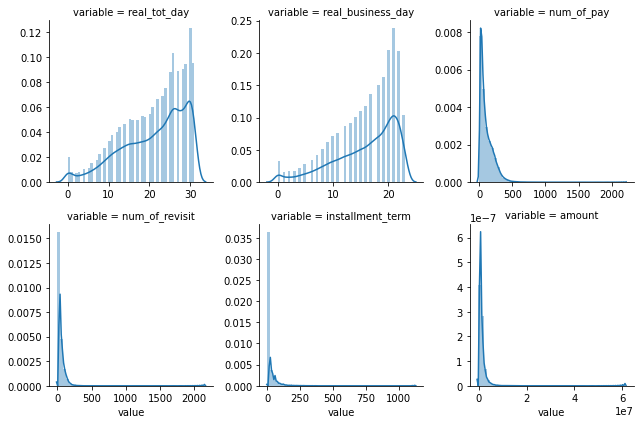

In [ ]:
f = pd.melt(df_month, value_vars=df_month.columns[1:])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show() 

## 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인(0~7)

* 각 store_id 별로 다른 trend와 seasonality, scale을 가지는 것을 확인할 수 있음

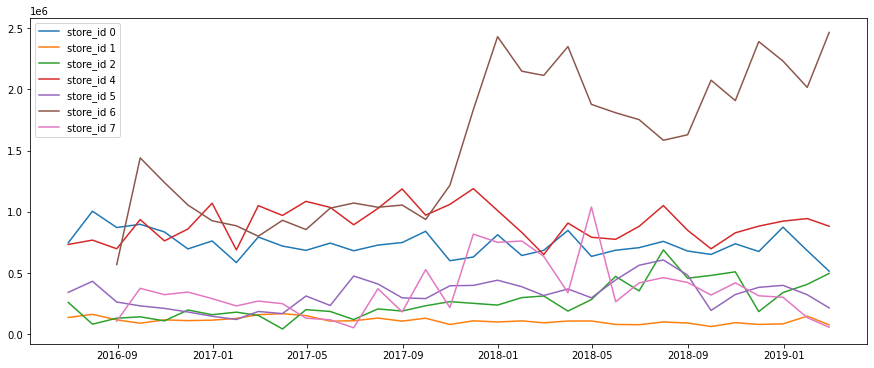

In [ ]:
plt.figure(figsize=(15, 6))
for i in df_month.store_id.unique()[:7]:
    plt.plot(df_month[df_month.store_id == i].index, df_month[df_month.store_id == i].amount, label='store_id {}'.format(i))
plt.legend()

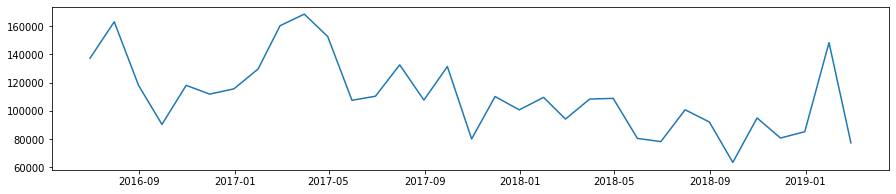

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(df_month[df_month.store_id == 1].index, df_month[df_month.store_id == 1].amount)

## 다른 변수들이 'amount'와 같은 pattern을 가지는지 확인

In [ ]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

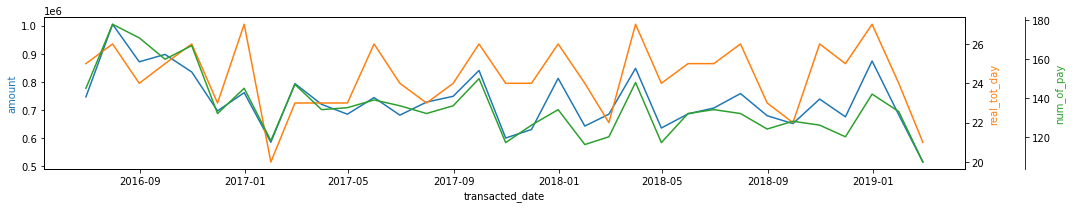

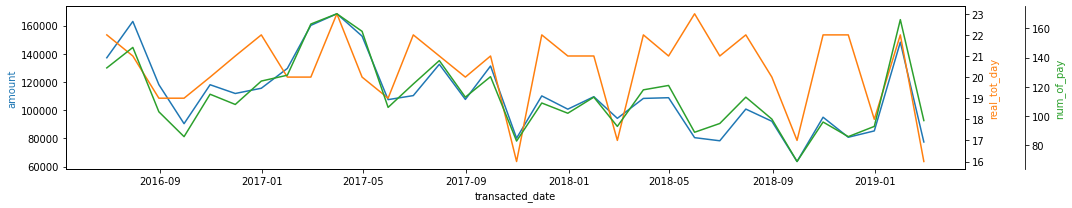

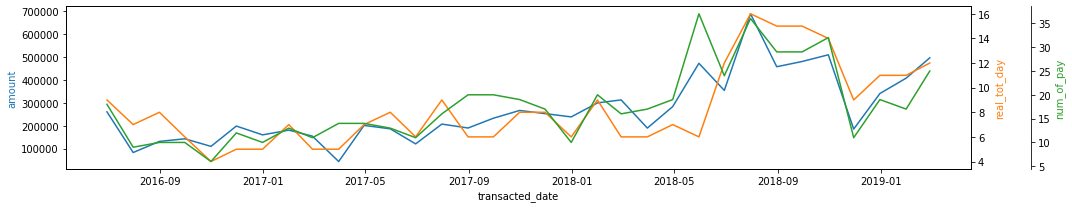

In [ ]:
for i in df_month.store_id.unique()[:3]:
    plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'num_of_pay'])

# STEP3. Modeling - Time Series

## Simple Moving Average
* 단순이동평균은 특정 기간 동안의 data를 단순 평균하여 계산한다. 따라서 그 기간 동안의 data를 대표하는 값이 이동평균 안에는 그 동안의 data 움직임을 포함하고 있다.
* 이동평균의 특징인 지연(lag)이 발생하며 수학적으로 n/2 시간 만큼의 지연이 발생한다.
* 단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.
* SMAt = Dt−(n−1)+Dt−(n−2)+⋯+Dt−1+Dt / n

In [ ]:
def make_sma_arr(window_num): #단순이동평균 함수 만들기
    ma_arr = np.array([]) #빈 배열 하나 만들어주고
    for i in df_month.store_id.unique():
        df_set = df_month[df_month.store_id == i]
        ma_arr = np.concatenate((ma_arr, df_set.amount.rolling(window=window_num).mean().values))
        #concatenate은 모양이 같은 array를 하나의 array로 합치는 것
        #ma_arr과 df_set.amount.rolling(window=window_num).mean().values를 합치는 모양
        #rolling은 괄호 안 숫자만큼 데이터를 밀어내서 순서를 조정함
        #함수에 입력한 변수 window_num만큼 rolling
        #mean으로 그것들의 평균을 구하고, 평균들 array랑 ma_array를 합침
    return ma_arr
    #합친 걸 보여줌

In [ ]:
sma_month = df_month.copy()
#sma_month에 df_month를 복사붙여넣음
sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
#그 데이터셋에 열을 하나씩 추가하여 각 열에 이동평균을 window_num에 따라 계산해서 추가
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

In [ ]:
sma_month.head(7)
#그렇게 구한 데이터셋의 맨 첫 7줄을 보여줌

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_2ma,amount_3ma,amount_6ma
transacted_date,,,,,,,,,,
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,nan,nan,nan
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,876000.00000,nan,nan
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,938285.71429,874523.80952,nan
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286,884714.28571,924809.52381,nan
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143,866642.85714,868285.71429,nan
2016-11-30,0,23,15.00000,132.00000,93.00000,21.00000,697000.00000,766214.28571,810095.23810,842309.52381
2016-12-31,0,27,18.00000,145.00000,103.00000,11.00000,761857.14286,729428.57143,764761.90476,844785.71429


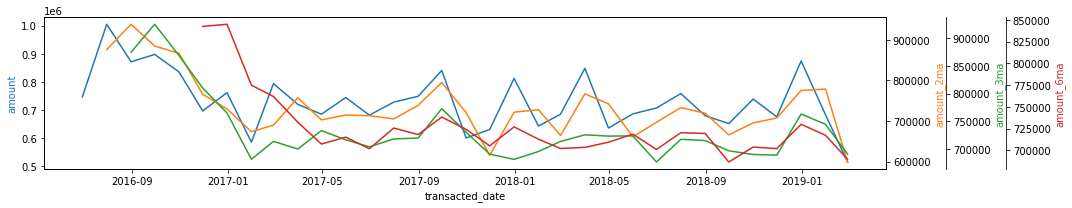

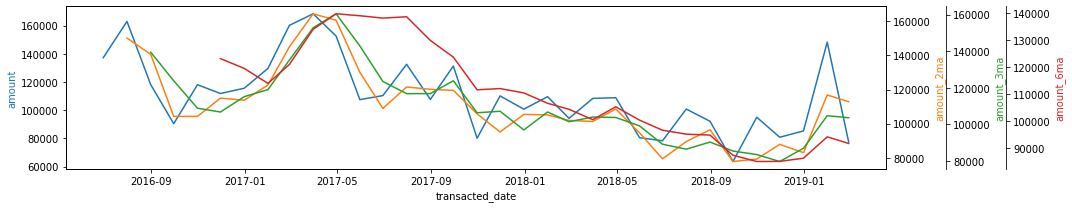

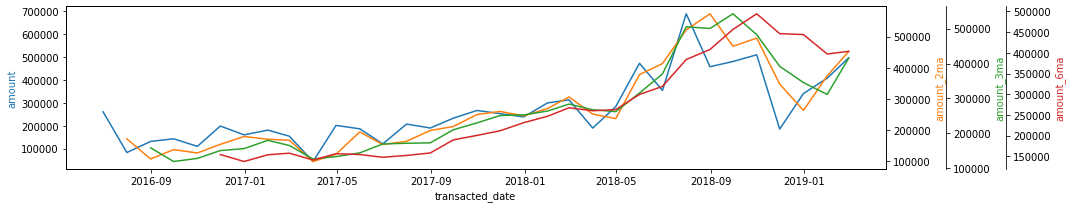

In [ ]:
for i in sma_month.store_id.unique()[:3]:
    plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [ ]:
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.45528312284
6 window SMA MAE Score :  387465.0993765708


* rolling의 경우, window 3를 예를 들면 t 시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다.
* 우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행

In [ ]:
def make_minus_rolling(data_frame, rolling_num): #함수 만들기
    def minus_shift_rolling(df_num, num):
        a = np.average(df_num.values[-num:]) #뒤의 num개수 만큼의 평균
        b = np.average(np.append(df_set.values[-(num-1):], a))
        #num개수보다 1작은 수만큼 뒷부분과 a를 합친 array의 평균
        if num > 2: #num이 2보다 크면 c는 num-2만큼 뒷부분의 array를 a랑 합치고 b랑 합친 거의 평균이 c
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
        else: #2보다 안크면 안 합치고 a,b의 평균이 c
            c = np.average((a, b))
        return np.sum((a, b, c)) #a,b,c의 합
        #근데 왜 a,b,c의 합을 구하는지 잘 모르겠음

    minus_rolling_arr = np.array([]) #빈 배열로 일단 채우기
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        #데이터셋의 매출 부분을 뽑아냄
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)])))
        #위에서 구한 minusshiftrolling이랑 같이 합침
    df_rolling = pd.DataFrame({'store_Id' : df_sub.store_id, 'amount' : minus_rolling_arr})
    #스토어 아이디랑 매출 데이터셋 만듬
    return df_rolling

In [ ]:
for i in range(2, 5): #각 번호마다 파일 만들어서 저장
    df_rolling = make_minus_rolling(df_month, i)
    df_rolling.to_csv('/content/drive/My Drive/Colab Notebooks/Time-Series/__data/sub/funda_{}_rolling_sub.csv'.format(i), index=False)

* SMA 2 rolling Score : 836184.506520
* SMA 3 rolling Score : 831158.397180
* SMA 4 rolling Score : 854300.339380

##Exponential Moving Average
* 지수이동평균은 가중이동평균 중의 하나로 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법이다.

* EMAt = Dt×(2 / N+1) + EMAt−1 × (1 − (2 / N+1))

In [ ]:
def make_ewm_arr(data_frame, span_num): #지수이동평균함수
    arr_ewm = np.array([])
    for i in data_frame.store_id.unique():
        df_set = data_frame[data_frame.store_id == i]
        # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다.
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [ ]:
ewm_month = df_month.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(df_month, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(df_month, 6))

In [ ]:
ewm_month.head(3)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_3ewm,amount_6ewm
transacted_date,,,,,,,,,
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,747000.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,919000.00000,897500.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,891897.95918,885844.03670


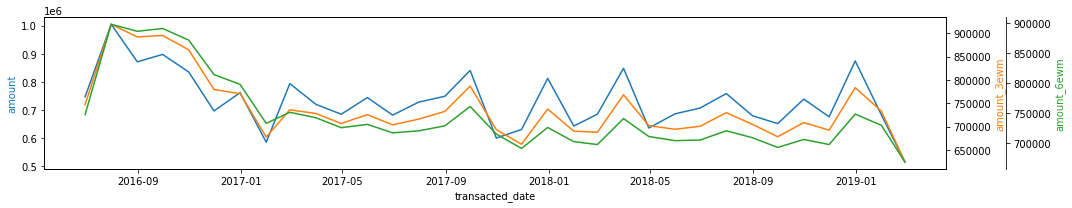

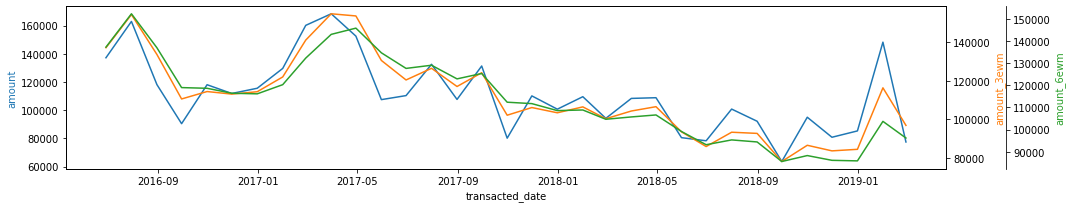

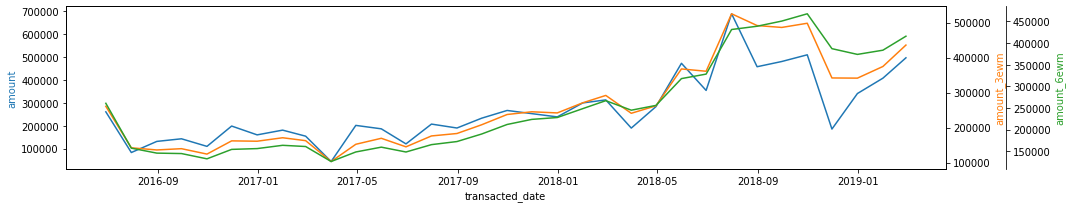

In [ ]:
for i in ewm_month.store_id.unique()[:3]:
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [ ]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915495
6 N EWM MAE Score :  193447.63093078104


* 3~7 Exponential Weighted Moving Score 확인

In [ ]:
def make_wma_sub(data_frame, span_num):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    wma_sub = np.array([])

    for i in df_month.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        wma_train = pd.concat([df_set, concat_3mon], axis=0)

        num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])

        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
    
    return df_wma_sub

In [ ]:
for i in range(2, 7):
    wma_sub = make_wma_sub(df_month, i)
    wma_sub.to_csv('/content/drive/My Drive/Colab Notebooks/Time-Series/__data/sub/funda_{}wma_sub.csv'.format(i), index=False)

* 2 span 제출 Score : 820102.106670
* 3 span 제출 Score : 785488.281930
* 4 span 제출 Score : 770667.895320
* 5 span 제출 Score : 767498.551420
* 6 span 제출 Score : 770414.027040

##Exponential Smoothing (지수평활법 - Simple, Holt's, Holt-Winter's)


### 1) Simple Exponential Smoothing

* trend나 seasonality 반영을 하지 못함
* level 정도만 수평선으로 나옴


---


* Ft = Ft−1 + α(Dt−1 − Ft−1)
 
* Ft = (1 − α) Ft−1 + αDt−1


---


 
* Ft  : 현재 시점의 예측 값
* Ft−1  : 이전 시점의 예측 값
* Dt−1  : 이전 시점의 실제 값
* α  : smoothing 요소, 0 <  α  < 1

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

ses_model = SimpleExpSmoothing(train.amount)
ses_result = ses_model.fit()
ses_pred = ses_result.forecast(len(test))
#그냥 함수가 알아서 해주네영...

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



In [ ]:
print("store_id 0 mean value : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, ses_pred))

store_id 0 mean value :  732559.7402597402
MAE Score of test : 78218.11194659187


In [ ]:
def plot_train_test_pred_graph(trainset, testset, pred):
    plt.figure(figsize=(15,3))
    plt.plot(trainset.amount, label='train')
    plt.plot(testset.amount, label='test')
    plt.plot(testset.index, pred, label='prediction')
    plt.legend()
    plt.show()

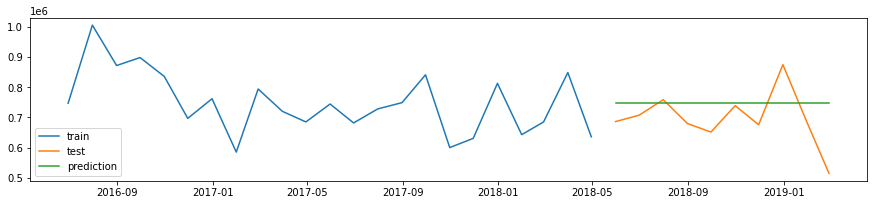

In [ ]:
plot_train_test_pred_graph(train, test, ses_pred)

In [ ]:
ses_pred_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    ses_model = SimpleExpSmoothing(df_set.amount)
    ses_result = ses_model.fit()
    ses_pred = ses_result.forecast(3)
    
    ses_pred_arr = np.concatenate((ses_pred_arr, np.array([ses_pred.sum()])))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/t

In [ ]:
df_ses_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : ses_pred_arr})

* Simple Exponential Smoothing Score : 818205.82245

### 2) Holt's Exponential Smoothing
* trend로 데이터를 예측하기 위해 Simple Exponential Smoothing에서 확장한 것이다.
* 예측을 위한 식 외에 level smoothing을 위한 식과 trend smoothing을 위한 식이 포함된다
* 생성된 예측은 선형적으로 나타나기 때문에 예측 범위가 멀어질 수록 over-forecast 되는 경향이 있다.



---


* Forecast equation : y't+h|t = lt + hbt
* Level equation : lt = αyt + (1 − α)(lt−1 + bt−1)
* Trend Equation : bt = β∗(lt − lt−1) + (1−β∗)bt−1

---

* lt  : t 시점에서의 level(수준)의 추정을 나타낸다.
* bt  : t 시점에서의 추세(경사)의 추정을 나타낸다.
* α  : level(수준)에 대한 smoothing parameter이고 다음과 같음 범위를 갖는다. 0 <  α  < 1
* β∗  : trend(추세)에 대한 smoothing parameter이고 다음과 같은 범위를 갖는다. 0 <  β∗  < 1
* level에 대한 식  lt 는 t 시간에 대한 관측치  yt 와 훈련 예측  lt−1+bt−1 의 가중 평균을 나타낸다.
* trend에 대한 식  bt 는  (lt−lt−1) 에 근거한 t시간에 대한 추정치와 이전 추정치인  bt−1 의 가중 평균을 나타낸다.

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

holt_model = Holt(np.array(train.amount))
holt_result = holt_model.fit()
holt_pred = holt_result.forecast(len(test))

Mean value of store_id 0 :  732559.7402597402
MAE Score of test : 104762.75933861124


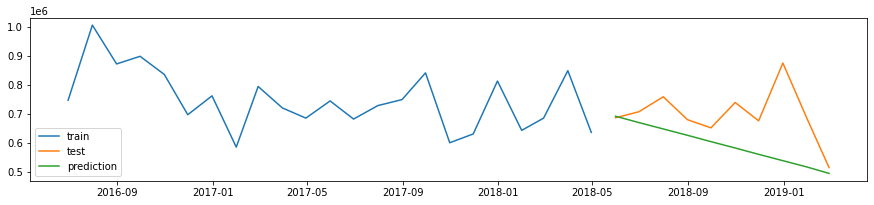

In [ ]:
print("Mean value of store_id 0 : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, holt_pred))

plot_train_test_pred_graph(train, test, holt_pred)

In [ ]:
%%time
holt_pred_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    holt_model = Holt(np.array(df_set.amount))
    holt_result = holt_model.fit()
    holt_pred = holt_result.forecast(3)
    
    holt_pred_arr = np.concatenate((holt_pred_arr, np.array([holt_pred.sum()])))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimizati

CPU times: user 20.1 s, sys: 269 ms, total: 20.3 s
Wall time: 19.9 s


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
holt_sub = pd.DataFrame({'sotre_id' : df_sub.store_id, 'amount' : holt_pred_arr})

* Holt's Exponential Smoothing Score : 926470.756080


### 3) Holt-Winter's Exponential Smoothing
* Holt-Winter's 방법은 seasonality를 반영하기 위해 Holt's 방법에서 확장된 것이다.
* Holt-Winter's 방법은 예측식과 3개의 smoothing 식으로 구성되어 있다.
>* level에 대한 식  lt
>* trend에 대한 식  b − t 
>* seasonal에 대한 요소  st 
>* smoothing parameter에 해당하는  α ,  β∗ ,  γ 
* seasonality의 빈도를 나타내기 위한  m 
seasonal이 변화하는 형태에 따라 두 가지 방법이 있다.
>* additive : seasonal의 변화가 일정하게 지속될 때
>* multiplicative : seasonal의 변화가 level에 비례적일 때


---


* Forecast equation : y't+h|t = lt + hbt + st+h−m(k+1)
* Level equation : lt = α(yt − st−m) + (1 − α)(lt−1 + bt−1)
* Trend equation : bt=β∗(lt − lt−1) + (1 − β∗)bt−1
* Seasonal equation : st = γ(yt − lt−1 − bt−1) + (1−γ)st−m
 
---

* level에 대한 식은 t 시간에 대한 조정된 seasonally 관측치  (yt−st−m) 와 non-seasonally 예측치  (lt−1+bt−1) 의 가중 평균을 나타낸다.
* trend에 대한 식은 Holt's 선형식에서와 동일하다.
* seasonal에 대한 식은 현재 seasonal 지수  (yt−lt−1−bt−1) 와 이전 seasonal 지수( m 기간 전) 사이의 가중 평균을 나타낸다.

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

# 최적값을 찾기 위한 기준
es_score = 1000000000
best_period = 0
# 각 store_id 최적의 seasonal period를 찾기 위한 탐색
for p in range(2,(len(train)//2) + 1):
    try:
        es_model = ExponentialSmoothing(np.array(train.amount), seasonal_periods=p, trend='add', seasonal='add')
        es_result = es_model.fit()
        es_pred = es_result.forecast(len(test))

        if es_score > mae(test.amount, es_pred):
            es_score = mae(test.amount, es_pred)
            best_period = p
    except:
        continue

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimizati

Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 63279.99423602336
Best seasonal period : 4


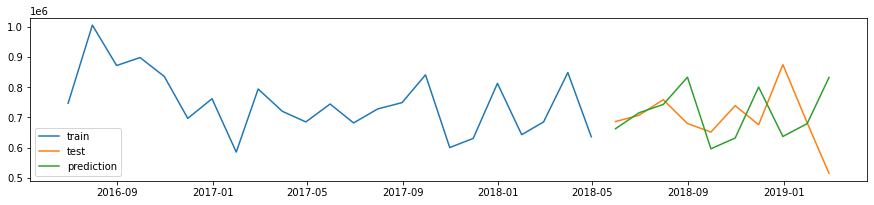

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", es_score)
print("Best seasonal period :", best_period)

plot_train_test_pred_graph(train, test, es_pred)

In [ ]:
%%time
holt_winters_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]

    size = int(len(df_set) * 0.7)
    train = df_set[:size]
    test = df_set[size:]
    
    # 최적값을 찾기 위한 기준
    es_score = 1000000000
    best_period = 0
    # 각 store_id 최적의 seasonal period를 찾기 위한 탐색
    for p in range(2,(len(train)//2) + 1):
        try:
            es_model = ExponentialSmoothing(np.array(train.amount),seasonal_periods=p, trend='add', seasonal='add')
            es_result = es_model.fit()
            es_pred = es_result.forecast(len(test))

            if es_score > mae(test.amount, es_pred):
                es_score = mae(test.amount, es_pred)
                best_period = p
        except:
            continue
    
    # 최적의 parameter을 이용한 3개월 예측과 sum
    set_es_model = ExponentialSmoothing(np.array(df_set.amount), seasonal_periods=best_period, trend='add', seasonal='add')
    set_es_result = set_es_model.fit()
    set_es_pred = set_es_result.forecast(3)
    
    holt_winters_arr = np.concatenate((holt_winters_arr, np.array([set_es_pred.sum()])))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/p

CPU times: user 19min 45s, sys: 31.2 s, total: 20min 16s
Wall time: 19min 37s


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
holt_winters_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : holt_winters_arr})
holt_winters_sub.to_csv('/content/drive/My Drive/Colab Notebooks/__data/sub/funda_holt_winters_sub.csv', index=False)

* Holt-Winter's Exponential Smoothing Score : 962259.599880

##ARMA
* ARMA(p,q) 모형은 AR(p) 모형과 MA(q) 모형의 특징을 모두 가지는 모형이다. 즉, p개의 자기 자신의 과거값과 q개의 과거 백색 잡음의 선형 조합으로 현재의 값이 정해지는 모형이다.
> Yt= − ϕ1Yt−1 − ϕ2Yt−2 − ⋯ − ϕpYt−p + ϵt + θ1ϵt−1 + θ2ϵt−2 + ⋯ + θqϵt−q
 
* 많은 store_id들이  |ϕ|<1 의 AR 정상상태(stationary) 조건에 맞지 않아 1 이상의 p 값을 적용할 수 없다.
* 따라서 차분(difference)을 이용해 비정상상태(non-stationary)의 설명이 가능한 ARIMA를 추가로 진행한다.

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]#처음부터 size(15)-1까지
test = df_set[size:]#size(15)부터

set_arma = sm.tsa.ARMA(train.amount, (0, 2))
set_result = set_arma.fit()

set_output = set_result.forecast(len(test))
set_pred = set_output[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 80938.78193554627


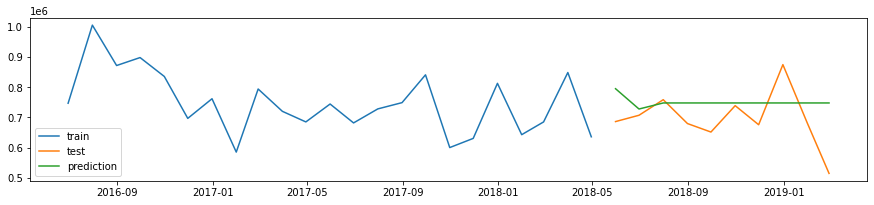

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, set_pred))

plot_train_test_pred_graph(train, test, set_pred)

In [ ]:
%%time
arma_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    # (0, 2) 모델로 진행을 하다 error가 발생하면 (0, 1)모델로 진행
    try:
        arma_model = sm.tsa.ARMA(df_set.amount, (0, 2))
        arma_result = arma_model.fit()
    except:
        arma_model = sm.tsa.ARMA(df_set.amount, (0, 1))
        arma_result = arma_model.fit()
        
    output = arma_result.forecast(3)
    
    arma_arr = np.concatenate((arma_arr, np.array([output[0].sum()])))

df_arma_0_2_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : arma_arr})
# (0, 2)로 진행했지만 nan값이 발생하는 경우 확인
df_null = df_arma_0_2_sub[df_arma_0_2_sub.amount.isnull()]
# nan값이 발생한 store_id는 (0, 1) 모델로 재진행
for i in df_null.store_id:
    df_set = df_month[df_month.store_id == i]

    arma_model = sm.tsa.ARMA(df_set.amount, (0, 1))
    arma_result = arma_model.fit()

    output = arma_result.forecast(3)

    idx_num = df_arma_0_2_sub[df_arma_0_2_sub.store_id == i].index.values[0]
    df_arma_0_2_sub[idx_num:idx_num + 1] = output[0].sum()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-

CPU times: user 1min 24s, sys: 823 ms, total: 1min 25s
Wall time: 1min 25s


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



In [ ]:
df_arma_0_2_sub.to_csv('/content/drive/My Drive/Colab Notebooks/Time-Series/__data/sub/funda_adj_arma_0_2_sub.csv', index=False)

* ARMA Score : 984368.752690

## ARIMA(Autoregressive Integrated Moving Average)
* ARIMA 모델은  Yt 을 차분(difference)한 결과로 만들어지 시계열  ∇Yt=Yt−Yt−1 이 ARMA 모형을 따르면 원래의 시계열  Yt 를 ARIMA 모형이라고 한다.
* 만약  d 번 차분한 후예야 시계열  ∇dYt 가 ARMA(p,q) 모형을 따른다면 적분 차수가(order of integration)가 d인 ARIMA 모형으로 ARIMA(p, d, q)로 표기한다.
* q=0인 경우에는 ARI(p,d), q=0인 경우에는 IMA(d,q)로 표기한다.
* p, d, q의 조합을 탐색하며 최적 parameter를 찾고 기준은 fit에 저장되어 있는 AIC(Akaike's Information Criterion)을 기준으로 한다. 다음과 같은 식을 가지며 작을 수록 좋은 모형이다.
* AIC=−2log(Likelihood)+2K
 
> * k  : 모델의 추정된 parameter의 갯수
> * Likelihood  : 모델의 likelihoood function의 최댓값

In [ ]:
p = list(range(0, 6))
d = [0, 1, 2]
q = list(range(0, 6))

pdq = list(itertools.product(p, d, q))

In [ ]:
%%time
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

best_score = 10000000
best_param = 0
for param in pdq:
    try:
        arima_model = ARIMA(train.amount.values, order=param)
        result = arima_model.fit()
        if result.aic < best_score:
            best_score = result.aic
            best_param = param
    except:
        continue
        
set_arima = ARIMA(df_set.amount.values, order=best_param)
set_result = set_arima.fit()
set_pred = set_result.forecast(len(test))[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492

CPU times: user 9.12 s, sys: 853 ms, total: 9.98 s
Wall time: 8.99 s


Mean value of store_id 0 : 732559.7402597402
AIC Score of test : 557.6623843461919
Best parameter of (p, d, q):  (2, 2, 1)


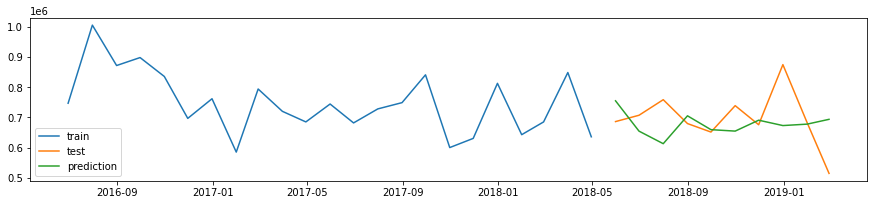

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("AIC Score of test :", best_score)
print("Best parameter of (p, d, q): ",best_param)

plot_train_test_pred_graph(train, test, set_pred)

In [ ]:
%%time
arima_pred_arr = np.array([])
for i in df_month.store_id.unique()[:10]:
    df_set = df_month[df_month.store_id == i]

    best_score = 10000000000
    best_param = 0
    for param in pdq:
        try:
            arima_model = ARIMA(df_set.amount.values, order=param)
            result = arima_model.fit()
            # 최적 parameter는 fit에 저장되어 있는 AIC값을 기준으로 선정 한다.
            if result.aic < best_score:
                best_score = result.aic
                best_param = param
        except:
            continue

    
    arima_model = ARIMA(df_set.amount.values, order=best_param)
    arima_result = arima_model.fit()
    arima_pred = arima_result.forecast(3)[0]

    arima_pred_arr = np.concatenate((arima_pred_arr, np.array([arima_pred.sum()])))

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: Hessia

CPU times: user 4min 11s, sys: 31.1 s, total: 4min 42s
Wall time: 4min 5s


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



In [ ]:
arima_sum_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : arima_pred_arr})
arima_sum_sub.to_csv('/content/drive/My Drive/Colab Notebooks/__data/sub/funda_arima_front_sum_sub.csv', index=False)

ValueError: ignored

* ARIMA MAE Score : 1080182.482790

## Facebook Prophet
* prophet은 페이스북에서 개발한 시계열 예측 패키지이다. * ARIMA와 같이 확률론적이고 이론적인 모형이 아닌 몇가지 경험적 규칙(heuristic rule)을 사용하는 단순 회귀 모형이지만 단기적 예측에서는 큰 문제 없이 사용할 수 있다.
* prophet은 다음 순서로 시계열에 대한 회귀분석 모형을 만든다.
> * 시간 데이터의 각종 특징을 임베딩하여 계절성 추정을 한다.
> * 나머지 데이터는 구간별 선형회귀(piecewise linear regression) 분석을 한다. 구간 구분점을 change point라고 한다.
* prophet을 사용하기 위해서는 ds, y 2개의 column만을 정의하여 사용해야 한다.
* prophet은 다음과 같이 Growth, Seasonality, Holidays로 구성되어 있다.
>> y(t)=g(t)+s(t)+h(t)+error
 
* g(t) : Growth, 'linear'와 'logistic'으로 구분되어 있다.
* s(t) : Seasonality
* h(t) : Holidays, 계절성을 가지진 않지만 전체 추이에 영향을 주는 이벤트를 의미하며 이벤트의 효과는 독립적이라 가정한다.

In [ ]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [ ]:
# prophet은 ds와 y 두 개의 column으로만 진행
df_prophet = pd.DataFrame({'ds' : train.index, 'y' : train.amount}).reset_index(drop=True) 

prophet_model = Prophet() # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
result = prophet_model.fit(df_prophet)

prophet_test = pd.DataFrame(test.index).rename(columns={'transacted_date' : 'ds'})
prophet_pred_df = result.predict(prophet_test)
prophet_pred = prophet_pred_df.yhat

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, prophet_pred))

plot_train_test_pred_graph(train, test, prophet_pred)

In [ ]:
%%time
front_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    # 각 store_id를 prophet에 맞는 dataframe의 형태로 생성('ds', 'y' columns)
    df_prophet = pd.DataFrame({'ds' : df_set.index, 'y' : df_set.amount}).reset_index(drop=True)
    
    # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' growth를 사용하지 않고 default인 'linear' growth 사용
    prophet_model = Prophet() 
    result = prophet_model.fit(df_prophet)

    # 예측할 date를 prophet 예측에 맞는 dataframe 형태로 생성
    extend_date = pd.date_range(start=df_set.index[-1], end=dt.strptime('2019-05-31', "%Y-%m-%d"), freq='m')[1:]
    extend_future = pd.DataFrame(extend_date).rename(columns = {0 : 'ds'})
    forecast = result.predict(extend_future)
    
    front_arr = np.concatenate((front_arr, np.array([forecast.yhat[:3].sum()])))

In [ ]:
df_prophet_front_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : front_arr})

In [ ]:
df_prophet_front_sub.to_csv('/content/drive/My Drive/Colab Notebooks/Time-Series/__data/sub/funda_prophet_front_sub.csv', index=False)

* Facebook prophet 3 Score : 1221173.032530

##Time-Series Model 최종 Score
* Simple Moving Average(3 rolling) : 831,158.397180
* Exponential Moving Average(5 span) : 767,498.551420
* Simple Exponential Smoothing : 818,205.822450
* Holt's Exponential Smoothing : 926,470.756080
* Holt-Winter's Exponential Smoothing : 962,259.599880
* ARMA model : 984,368.752690
* ARIMA model : 1,080,182.482790
* Facebook prophet : 1,221,173.032530

# Step4. Modeling - Regression

## **Regression을 적용하기 위해 해결해야 할 Issues**
* 1) datetime의 index를 numeric 변수로 변경해야한다. => 'year' 변수와 'month' 변수 생성
* 2) 예측해야할 각 store_id의 3월~5월에 대한 정보가 없다. => 각 store_id별 'year', 'month'변수의 정보만 채워 data frame 생성
* 3) 'store_id', 'year', 'month' 변수 이외의 변수들의 정보를 채울 수가 없다.
* 회귀 분석 알고리즘으로 target 변수 이외의 변수를 예측하여 채워 넣고 그 데이터로 target 변수를 예측한다.
* 'store_id', 'year', 'month' 변수 만으로 target 변수를 예측한다.

## 1) index를 'year', 'month' 변수로 변환
* 회귀분석을 하기 위해서는 모든 변수들의 값이 numeric 해야 한다.
* date의 각 year, month를 변수로 변환

In [ ]:
df_month_reg = df_month.copy()

df_month_reg.insert(1, 'year',df_month_reg.index.year)
#두번째 열에 year이라는 이름의 인덱스를 추가하고 이것의 위치는 df_month_reg.index.year라는 값을 의미하는 것 같은데..
#참고로 첫번째 열의 자리는 0으로 표시함
#존재하지 않는 이 데이터는 어디서 오는 것인건가?
df_month_reg.insert(2, 'month',df_month_reg.index.month)

df_month_reg.reset_index(drop=True, inplace=True)
#index를 숫자로 다시 정렬하고, 기존 index(transacted date)는 drop으로 삭제
#inplace는 modify한 dataframe을 return함

In [ ]:
df_month.head(3)

In [ ]:
df_month_reg.head(3)
#위에서 만든 dataframe 맨 위 3줄 반환

## 2) 예측해야할 각 'store_id'의 2019-03 ~ 2019-05월 대한 data frame 생성
* 회귀변수는 단 하나의 값만 예측하기 때문에 2019/03~2019/05에 대한 각 'amount'를 예측하고 sum한다.
* 입력할 수 있는 'store_id'와 'year', 'month'를 제외한 변수들의 값은 0으로 대체한다.

In [ ]:
%%time
df_problem = pd.DataFrame()
#새로운 데이터프레임 생성
for i in df_month_reg.store_id.unique():
  #개별 스토어 아이디 당
    df_add = pd.DataFrame({'store_id' : i, 'year' : 2019, 'month' : [3, 4, 5]}, columns=df_month_reg.columns)
    #새로운 데이터 프레임 생성
    #column은 기존에서 가져오고 년도가 2019, month가 3,4,5로 채워진 열을 생성
    df_problem = pd.concat([df_problem, df_add], axis=0)
    #그리고 만들어둔 데이터 프레임에 넣어둠

df_problem.fillna(0, inplace=True)
#나머지 null값들은 모두 0으로 대체

## 3) Regression을 위해 사용할 변수들 설정
* 'store_id', 'year', 'month' 이외 변수들의 값을 예측하여 채우는 version1
* 'store_id', 'year', 'month'만 사용하는 version2

In [ ]:
# 각 columns values 예측을 위해 사용할 알고리즘들의 score 확인
def predict_columns(data_frame, x_cols, y_col):
    size = int(len(data_frame) * 0.7)  #데이터프레임의 앞 70%는 trainset이고, 나머지 30%는 test set
    train = data_frame[:size]
    test = data_frame[size:]
    
    reg_models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), GradientBoostingRegressor(), SVR(), XGBRegressor()]
    #여러가지 모델들
    reg_model_names = ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "GradientBoositng", " SupportVector", "XGBoost"]
    #모데들의 이름

    for i in range(len(reg_models)):#모델들의 개수의 range만큼 i를 돌림
        reg = reg_models[i].fit(train[x_cols], train[y_col])
        #i=0일 시, reg = LinearRegression.fit(train[x_cols], train[y_col])
        #데이터 프레임에 있는 정보들을 갖고 모델 트레이닝함
        pred = reg_models[i].predict(test[x_cols])
        #예측은 그 해당 모델로 test set에 넣는 건가? 아니면 test set이랑 비교하는건가?
        print('{} : {}'.format(reg_model_names[i], mae(test[y_col], pred.astype(int))))
        #ex) LinearRegression : 일정한 값
        #초반에 만들어둔 mae를 활용, int로 출력하는 듯

In [ ]:
predict_columns(df_month_reg, ['store_id', 'year', 'month'], 'real_tot_day')
#회귀분석용으로 만들어둔 데이터 프레임 활용

In [ ]:
size = int(len(df_month_reg) * 0.7)
train = df_month_reg[:size]
test = df_month_reg[size:]

In [ ]:
%%time
svr_model = SVR().fit(train[['store_id', 'year', 'month']], train['real_tot_day'])
svr_pred = svr_model.predict(df_problem[['store_id', 'year', 'month']])
df_problem.real_tot_day = svr_pred.astype(int)

linear_model = LinearRegression().fit(train[['store_id', 'year', 'month', 'real_tot_day']], train['real_business_day'])
linear_pred = linear_model.predict(df_problem[['store_id', 'year', 'month','real_tot_day']])
df_problem.real_business_day = linear_pred.astype(int)

linear_model = LinearRegression().fit(train[['store_id', 'year', 'month', 'real_tot_day', 'real_business_day']], train['num_of_pay'])
linear_pred = linear_model.predict(df_problem[['store_id', 'year', 'month','real_tot_day', 'real_business_day']])
df_problem.num_of_pay = linear_pred.astype(int)

linear_model = LinearRegression().fit(train[['store_id', 'year', 'month', 'real_tot_day', 'real_business_day', 'num_of_pay']], train['num_of_revisit'])
linear_pred = linear_model.predict(df_problem[['store_id', 'year', 'month','real_tot_day', 'real_business_day', 'num_of_pay']])
df_problem.num_of_revisit = linear_pred.astype(int)

svr_model = SVR().fit(train[['store_id', 'year', 'month', 'real_tot_day', 'real_business_day', 'num_of_pay', 'num_of_revisit']], train['installment_term'])
svr_pred = svr_model.predict(df_problem[['store_id', 'year', 'month', 'real_tot_day', 'real_business_day', 'num_of_pay', 'num_of_revisit']])
df_problem.installment_term = svr_pred.astype(int)
#갖고 있는 변수들로 다른 변수를 하나씩 추가하여 model을 트레이닝 하고 있는 것 같다..
#그리고 3~5월 예측하려고 만든 데이터 프레임에 하나씩 넣어둠

In [ ]:
df_problem.head(3)

In [ ]:
df_problem.reset_index(drop=True, inplace=True)
#숫자 인덱스 추가하고 기존 인덱스 삭제
df_problem.isnull().sum()
#빈칸 개수 세기

In [ ]:
print(len(df_month_reg))
print(len(train))
print(len(test))
print(len(df_problem))

## 4) Regression Models 확인
* LinearRegression, Ridge, Lasso, ElasticNet, GradientBoostingRegression, SupportVectorRegression, XGBRregressor 사용

In [ ]:
cv = KFold(10, shuffle=True, random_state=0)
#K겹교차검증 : 모든 데이터가 최소 한 번은 테스트셋으로 쓰이도록 함
#10개로 모든 데이터를 쪼개서 0~9번째까지 모두 한 번씩 테스트 셋이 되어서 모델을 검증
#shuffle은 10개의 배치로 쪼개기 전에 데이터를 섞는지 안 섞는지
#random generator의 seed number

In [ ]:
size = int(len(df_month_reg) * 0.7)
train = df_month_reg[:size]
test = df_month_reg[size:]

In [ ]:
month_reg_x = df_month_reg.drop(['amount'], axis=1)
month_reg_y = df_month_reg['amount']
#예측해야 하는 데이터가 amount니까 기존 데이터셋에서 amount를 뺌
#그리고 amount를 따로 빼서 설정!

In [ ]:
%%time
reg_models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), GradientBoostingRegressor(), SVR(), XGBRegressor()]
reg_model_names = ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "GradientBoositng", " SupportVector", "XGBoost"]
for i in range(len(reg_models)):
    full_cols = -cross_val_score(reg_models[i], month_reg_x, month_reg_y, scoring="neg_mean_absolute_error", cv=cv)
    certain_cols = -cross_val_score(reg_models[i], month_reg_x[['store_id', 'year', 'month']], month_reg_y, scoring="neg_mean_absolute_error", cv=cv)
    
    print("{} : {} / {}".format(reg_model_names[i], full_cols.mean(), certain_cols.mean()))
#위에 쓰인 것과 비슷한 방법
#cross validitation : 교차 검증.
#validitation set을 추가하여 더 조정된 모델을 만듬

* MAE Score가 amount의 평균값보다 높거나 평균 수준으로 굉장히 높게 나왔음
* 추가적인 Regression 분석은 진행하지 않음

# Step5. Modeling - Deep Neural Network

## LSTM
* LSTM은 RNN(Recurrent Neural Neetwork)의 일종이다. RNN은 학습을 할 때, 현재 입력값 뿐만 아니라 이전에 들어온 입력 값을 함께 고려하기 때문에 시계열 데이터를 학습하기에 적합하다. 신경망 중간에 있는 hidden layer의 결과값들이 다시 입력값으로 들어가기 때문에 순환(Recurrent) 신경망(Neural Network)이라는 이름이 붙었다.

* 그러나 RNN은 만약 데이터가 너무 길어져 이를 표현하는 신경망이 깊어져야만 할 경우 문제가 발생한다. RNN은 역전파(Backpropagation)라는 방법을 통해 학습하는데, 그래디언트가 너무 작아져 학습이 잘 안되는 문제(Vanishing Gradient Problem)가 발생할 수 있다. 이 문제를 해결하기 위해 LSTM이 만들어졌다.

* LSTM은 cell state라는 개념을 도입하여 그 내부에 있는 gate들을 통해 어떤 정보를 기억하고 어떤 정보를 버릴지 추가적인 학습을 가능하게 한다. 이를 통해 RNN이 가진 문제를 해결할 수 있다.

* 신경망을 빠르고 수월하게 학습시키려면 데이터들의 범위를 -1에서 1사이의 값으로 정규화(normalization)시켜야 한다.
p0  의 값이 0인 경우를 대비하여 아래와 같은 식으로 normalization 진행
> ni = ((pi + 1) / ( p0 + 1 )) − 1

* 예측한 값을 원래의 값으로 되돌릴 때는 아래와 같은 denormalization 수식을 사용한다.
> pi = ( p0 + 1 )( ni + 1 ) − 1

In [ ]:
df_month_dl = df_month.copy()

normalized_arr = np.array([]) #정규화시켜서 넣을 변수를 만듬
for i in df_month_dl.store_id.unique():
    df_set = df_month_dl[df_month_dl.store_id == i].amount.values
    #매출 배열
    set_arr = np.array([(float(i + 1) / float(df_set[0] + 1))-1 for i in df_set])
    #각 매출 배열의 길이 만큼(for i in df_set부분)
    #df_set에 있는 매출값과 첫번째 매출 값을 비교하여 정규화 시킴
    #set_arr[0] = 0이 되는 것임
    normalized_arr = np.concatenate((normalized_arr, set_arr))
    #빈 배열에 정규화한 배열을 합침

df_month_dl.insert(7, 'normalize', normalized_arr)
#데이터프레임에 7번째 열로 정규화한 배열 삽입

In [ ]:
df_month_dl.head(3)
#예시 출력

In [ ]:
set_arr

In [ ]:
df_set = df_month_dl[df_month_dl.store_id == 0]
#df_set에 store_id==0인 부분의 데이터프레임만 넣음
dl_x = df_set.index.values
dl_y = df_set.normalize
#dl_x는 index값(그러니까 숫자)에 대한 배열
#dl_y는 정규화한 값에 대한 배열임

size = int(len(df_set) * 0.7)
x_train = dl_x[:size]
y_train = dl_y[:size]
x_test = dl_x[size:]
y_test = dl_y[size:]
#train셋과 test셋 분리

x_train = x_train.reshape(len(x_train), 1)
#한줄짜리로 reshape왜 하는건지...
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
#위랑 같은 뜻의 코드인 것 같은데...

x_test = x_test.reshape(len(x_test), 1)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
# 모델 생성
model = Sequential()

model.add(LSTM
          (input_dim=1,        # 입력으로 들어가는 데이터의 차원에 맞게 설정
           output_dim =50,     # LSTM layer로 들어가는 입력값 설정
           input_shape=(len(dl_x), 1),
           return_sequences=True))
model.add(Dropout(0.2))        # overfitting을 방지하기 위한 Dropout 설정(20%)

model.add(LSTM(100,
              return_sequences=False)) # Dense layer에 들어가기 전이므로 False
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('relu')) # linear, relu, sigmoid, softmax
# normalize로 value가 작아졌기 때문에 mse로 진행
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
model.fit(x_train, y_train, epochs=100, validation_split=0.05, verbose=0)

In [ ]:
lstm_pred = model.predict(x_test)
#예측값
df_lstm_test = pd.DataFrame([((df_set.amount[0] + 1) * (i + 1) - 1) for i in y_test.values], columns=['amount'], index=y_test.index)
#정규화한 것을 다시 풀어서 새로운 데이터프레임에 넣어줌
df_lstm_pred = pd.DataFrame([((df_set.amount[0] + 1) * (i + 1) - 1)[0] for i in lstm_pred], columns=['amount'])

In [ ]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE score of test :", mae(df_lstm_test, df_lstm_pred))

plot_train_test_pred_graph(df_set[:size], df_lstm_test, df_lstm_pred)

In [ ]:
%%time
lstm_sub_arr = np.array([])#새로운 데이터셋 생성
for i in df_month_dl.store_id.unique()[:20]:#20번째 가게까지
    df_set = df_month_dl[df_month_dl.store_id == i]
    #스토어 아이디 배열
    dl_x = df_set.index.values
    #그냥 순서 배열
    dl_y = df_set.normalize
    #정규화 값 배열

    dl_x = dl_x.reshape(len(dl_x), 1)
    dl_x = np.reshape(dl_x, (dl_x.shape[0], 1, dl_x.shape[1]))
    #자체 reshape... 왜 하는지 모를일

    # 모델 생성
    model = Sequential()
    model.add(LSTM(input_dim=1, output_dim =50, input_shape=(len(dl_x), 1), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=1))
    model.add(Activation('relu'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    #위와 같은 모델

  # 모델 학습
    model.fit(dl_x, dl_y, epochs=100, validation_split=0.05, verbose=0)

    target_date = pd.date_range(start=df_set.index[-1], end=dt.strptime('2019-05-31', "%Y-%m-%d"), freq='m')[1:]
    target_date = target_date.values.reshape(len(target_date), 1)
    target_date = np.reshape(target_date, (target_date.shape[0], 1, target_date.shape[1]))

    lstm_pred = model.predict(target_date)

    print("Value of store_id {} prediction :".format(i),lstm_pred.reshape(len(lstm_pred),))
#     pred_sum = sum([((df_set.amount[0] + 1) * (i + 1) - 1)[0] for i in lstm_pred])
#     lstm_sub_arr = np.concatenate((lstm_sub_arr, np.array([pred_sum])))

그러나 각 store_id별로 LSTM을 학습시켜 보니 제대로 예측을 하지 못하는 것으로 나타남

* 예측값이 0이 나오는 경우가 많음 => denormalize를 하면 첫번째 관측값으로 대체됨
* 위의 결과값을 보면 알 수 있습니다... denormalize방법을 바꾸거나 걍 LSTM모델이 별로인 듯.

# Conclusion
**Time Series Model**
* Exponetial Moving Average의 결과가 가장 좋았다.
* 상대적으로 단순한 모형들의 점수가 높았다.
* * Moving average 종류나 Exponential Smoothing에서도 Simple 모형
* * 뚜렷한 trend나 seasonality가 없거나 data의 수가 적어서 파악하기 힘든데 trend나 seasonality를 적용하는 복잡한 모형들을 사용해서인 것으로 추측됨

**Regression Model**